# 라이브러리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import sys
import urllib.request
from datetime import datetime, time, timedelta
import string
from tqdm import tqdm
import time as t
import seaborn as sns
from scipy.stats import pearsonr, shapiro, levene, spearmanr, ranksums, ttest_ind
import ast
client_id = ""          # 네이버 API id와 비밀번호를 입력하여야함.
client_secret = ""


# 검색량 찾기 함수
def df_search(keyword, details, stardate, enddate, ages, gender, device = 'mo', timeunit = 'date'):  
keyword = ['멜로가체질', '천우희', '패션'] # keyword list  
details = [['멜로가체질'], ['천우희'], ['패션', '옷', '블라우스']] # 세부검색  
startdate = '2019-01-01' # 시작날짜 형식:2022-01-03  
enddate = '2020-01-01' # 종료날짜  
ages = ['1','2','3'] # 연령대 1:0-12, 2:13-18, 3:19-24, 4:25-29, 5:30-34, 6:35-39, 7:40-44, 8:45-49, 9:50-54, 10:55-59, 11:60- 미입력시 전체  
gender = 'f' # 성별 m:남, f:여 미입력시 전체  
device = 'pc' # 검색도구 pc:pc, mo:모바일 미입력시 전체  
timeunit = 'date' # 시간단위 date:일간, week:주간, month:월간  

In [ ]:
def df_search(keyword, details, startdate, enddate, ages, gender, device = 'mo', timeunit = 'date'):
  url = "https://openapi.naver.com/v1/datalab/search";
  body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";
  body_json = json.loads(body)
  body_json['startDate'] = startdate
  body_json['endDate'] = enddate
  body_json['timeUnit'] = timeunit
  body_json['device'] = device
  if ages != '':
    body_json['ages'] = ages
  else:
    body_json['ages'] = ['1','2','3', '4','5','6','7', '8', '9', '10', '11']
  body_json['gender'] = gender

  body_json['keywordGroups'] = []
  for i in range(len(keyword)):
    body_json['keywordGroups'].append( {'groupName': f'{keyword[i]}', 'keywords': details[i]} )
  body = json.dumps(body_json, ensure_ascii=False)


  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_data = response_body.decode('utf-8')
  else:
      print("Error Code:" + rescode)

  result = json.loads(response_data)
  df = pd.DataFrame()

  # Iterate through each item in the 'results' list
  for item in result['results']:
      item_df = pd.DataFrame(item['data']).set_index('period')
      item_df.columns = [item['title']]

      # Append this DataFrame to the main DataFrame
      df = pd.concat([df, item_df], axis=1)

  df.fillna(0, inplace = True)
  df.reset_index(inplace=True)

  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace=True)
  df = df.reset_index(drop = True)

  return df

## 함수(search)

In [ ]:
def modify_detail(search_word, add_word, add = True):
  if add == True:
    for sub_list in detail_list:
      if search_word in sub_list:
        index2change = detail_list.index(sub_list)
        print(index2change, detail_list[index2change])
        detail_list[index2change].append(add_word)
        print(detail_list[index2change])
  else:
     for sub_list in detail_list:
      if search_word in sub_list:
        index2change = detail_list.index(sub_list)
        print(index2change, detail_list[index2change])


In [ ]:
def return_search_info(title):
  k = meta.loc[meta['작품명'] == title]
  keyword = [title, '기준']
  startdate = k.iloc[0, 5][:10]
  enddate = k.iloc[0, 6][:10]
  return keyword, startdate, enddate

## 검색 코드

In [ ]:
# 비교 기준과 병합용 table
standard = df_search(['기준'], [['구글']], '2019-01-01', '2023-07-01', ages = '', gender = '')
whole_join = standard.copy().set_index('period')


# night_list, detail_list 는 야간의 작품명들과 그것들의 세부 검색어 집합
for a in tqdm(range(len(night_list))):
  # df_search의 인자
  title = night_list[a]
  details = [detail_list[a], ['구글']]
  ages = ''
  gender = ''
  keyword, startdate, enddate = return_search_info(title)
  # 7월까지로 데이터 제한
  if enddate < '2023-07-01':
    pass
  else:
    enddate = '2023-07-01'

  # 비교가 가능하도록 조정
  t.sleep(0.1)
  k = df_search(keyword, details, startdate, enddate, ages, gender)
  value = standard.loc[standard['period'] == k.iloc[0,0], '기준'] / k.iloc[0,2]
  value = value.values[0]

  k.iloc[:, 1] = k.iloc[:, 1]*value

  whole_join = whole_join.join(k.iloc[:, :2].set_index('period'))


100%|██████████| 313/313 [05:46<00:00,  1.11s/it]


In [ ]:
# whole_join.to_csv('/content/whole_join.csv', encoding = 'utf-8-sig')
whole_join = pd.read_csv('/content/whole_join.csv', parse_dates = ['period'])

In [ ]:
whole_join['sum_search'] = whole_join.iloc[:, 2:].sum(axis=1)
drama_search= whole_join[['period', '기준', 'sum_search']]

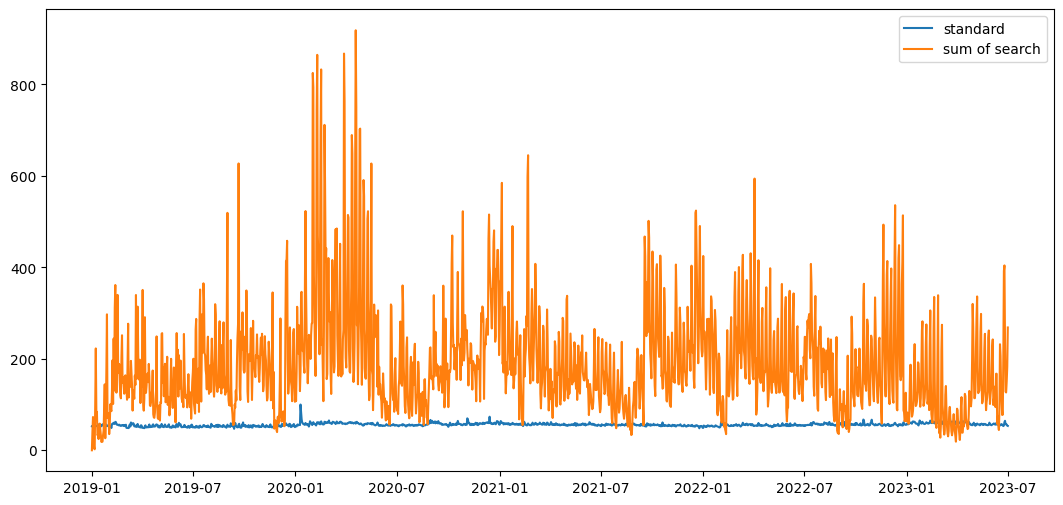

In [ ]:
plt.figure(figsize = (13, 6))
plt.plot(drama_search['period'], drama_search['기준'], label = 'standard')
plt.plot(drama_search['period'], drama_search['sum_search'], label = 'sum of search')
plt.legend()
plt.show()

# 쇼핑 검색량

## 함수
비교기준 : 유니클로  
shopping_keyword(startdate, enddate, keyword, catergory = "50000000")  # 50000000은 패션/의류 카테고리   
shopping_gender(startdate, enddate, keyword, category = "50000000")  
shopping_age(startdate, enddate, keyword, category = "50000000")  
plt_df(df)

In [ ]:
### 키워드 총량(기준 : 유니클로) ###
def shopping_keyword(startdate, enddate, keyword, catergory = "50000000"):

  url = "https://openapi.naver.com/v1/datalab/shopping/category/keywords"
  data = {
      "startDate": startdate,
      "endDate": enddate,
      "timeUnit": "date",
      "category": catergory,
      "keyword": [
          {"name": "유니클로", "param": [ "유니클로"]},
          {"name": keyword, "param": [keyword]}
      ],
      "device": "mo",
      "gender": "",
      "ages": []
  }

  body = json.dumps(data)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id", client_id)
  request.add_header("X-Naver-Client-Secret", client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_dict = json.loads(response_body.decode('utf-8'))
      print(response_dict)
  else:
      print("Error Code:" + str(rescode))

  result = json.loads(response_body.decode('utf-8'))
  df = pd.DataFrame()

  # Iterate through each item in the 'results' list
  for item in result['results']:
      item_df = pd.DataFrame(item['data']).set_index('period')
      item_df.columns = [item['title']]

      # Append this DataFrame to the main DataFrame
      df = pd.concat([df, item_df], axis=1)

  df.fillna(0, inplace = True)
  df.reset_index(inplace=True)

  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace=True)
  df = df.reset_index(drop = True)


  return df



In [ ]:
### 키워드의 성별 비교 ###
def shopping_gender(startdate, enddate, keyword, category = "50000000"):
  url = "https://openapi.naver.com/v1/datalab/shopping/category/keyword/gender"
  data = {
      "startDate": startdate,
      "endDate": enddate,
      "timeUnit": "date",
      "category": "50000000",
      "keyword": keyword,
      "device": "mo",
      "gender": "",
      "ages": []
  }

  body = json.dumps(data)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id", client_id)
  request.add_header("X-Naver-Client-Secret", client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_dict = json.loads(response_body.decode('utf-8'))
      print(response_dict)
  else:
      print("Error Code:" + str(rescode))


  result = json.loads(response_body.decode('utf-8'))
  df_data = []

  # 결과를 반복하여 각 행에 대한 데이터를 생성합니다.
  for res in result['results']:
      for item in res['data']:
          df_data.append({
              'period': item['period'],
              'ratio': item['ratio'],
              'group': item['group'],
          })

  # 데이터프레임을 생성합니다.
  df = pd.DataFrame(df_data)

  # "group" 열을 이용해서 피벗하여 "male"과 "female"열을 만듭니다.
  df = df.pivot(index='period', columns='group', values='ratio').reset_index()

  # "m"과 "f" 대신에 "male"과 "female"로 열 이름을 변경합니다.
  df.rename(columns={'m': 'male', 'f': 'female'}, inplace=True)

  df.fillna(0, inplace = True)
  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace = True)
  df = df.reset_index(drop = True)

  return df



In [ ]:
### 키워드의 연령 비교 ###
def shopping_age(startdate, enddate, keyword, category = "50000000"):
  url = "https://openapi.naver.com/v1/datalab/shopping/category/keyword/age"
  data = {
      "startDate": startdate,
      "endDate": enddate,
      "timeUnit": "date",
      "category": category,
      "keyword": keyword,
      "device": "",
      "gender": "",
      "ages": []
  }

  body = json.dumps(data)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id", client_id)
  request.add_header("X-Naver-Client-Secret", client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_dict = json.loads(response_body.decode('utf-8'))
      print(response_dict)
  else:
      print("Error Code:" + str(rescode))

  # json 풀기
  result = json.loads(response_body.decode('utf-8'))
  df_data = []

  # 각 행 데이터 생성
  for res in result['results']:
      for item in res['data']:
          df_data.append({
              'period': item['period'],
              'ratio': item['ratio'],
              'group': item['group'],
          })

  # 데이터프레임 생성
  df = pd.DataFrame(df_data)

  # "group" 열을 이용해서 피벗하여 연령대별 그룹 만들기
  df = df.pivot(index='period', columns='group', values='ratio').reset_index()
  df.fillna(0, inplace = True)
  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace = True)
  df = df.reset_index(drop = True)

  return df




In [ ]:
def plt_df(df):
  for a in df.columns[1:]:
    x = df['period']
    plt.plot(x, df[a], label = a)
  plt.legend()
  plt.show()

## 패션의류 카테고리에서의 검색량 확인

In [ ]:
# a = shopping_keyword("2019-01-01", "2020-01-01", "유니클로")
# b = shopping_keyword("2020-01-01", "2021-01-01", "유니클로")
# c = shopping_keyword("2021-01-01", "2022-01-01", "유니클로")
# d = shopping_keyword("2022-01-01", "2023-01-01", "유니클로")
# e = shopping_keyword("2023-01-01", "2023-07-21", "유니클로")

# k = [a, b, c, d, e]

In [ ]:
# # 유니클로로 기준
# for argu in range(5):
#   if argu != 0:
#     now = k[argu].copy()
#     x = before.iloc[-1, 1] / now.iloc[0, 1]
#     now.iloc[:,1] = now.iloc[:, 1] * x
#     shop_standard = pd.concat([before.iloc[:-1, :], now])
#     before = shop_standard
#   else:
#     before = k[argu]

# shop_standard = shop_standard.reset_index(drop = True)

In [ ]:
# error_list = []
# for name in dramalist:
#   try:
#     target = meta.loc[meta['작품명'] == name, ['시작일', '종료일']]
#     if target.iloc[0, 1] <= '2023-07-21':
#       table = shopping_keyword(str(target.iloc[0,0])[:10], str(target.iloc[0,1])[:10], name)
#     else:
#       table = shopping_keyword(str(target.iloc[0,0])[:10], '2023-07-21', name)

#     x = float(shop_standard.loc[shop_standard['period'] == table.iloc[0,0], '유니클로'] / table.iloc[0, 1]) # 유니클로가 기준
#     table.iloc[:,[1,2]] = table.iloc[:, [1,2]] * x  # 기준에 따라 정렬
#     table = table.drop('유니클로', axis =1)

#     shop_standard = shop_standard.merge(table, on = 'period', how = 'left')

#   except Exception as e:
#     error_list.append(name)
#     print(name)

In [ ]:
# print(len(error_list), error_list)

In [ ]:
# modifies = ['최고의치킨', '해치', '국민여러분', '에이틴', '녹두꽃', '이몽', '보이스3', '아스달연대기', '조선생존기', '레벨업', '신입사관구해령', '꽃파당',
#             '녹두전', '나의 나라', '레버리지', '간택', '터치', '바람과구름과비', '낮과밤', '바람피면 죽는다', '암행어사 조선비밀수사단', '루카', '달이 뜨는 강', '시지프스', '괴물',
#             '마우스', '어쩌다가족', '나빌레라', '보쌈', '마인', '멀리서보면푸른봄', '보이스4', '홍천기', '연모', '아이돌 더 쿠데타', '옷소매붉은 끝동', '태종이방원', '꽃피면달생각하고',
#             '기상청 사람들', '킬힐', '돼지의왕', '별똥별', '지금부터 쇼타임', '구필수는 없다', '이브','왜 오수재인가', '클리닝업', '아다마스', '조선정신과의사유세풍', '블라인드', '디엠파이어',
#             '금혼령', '트롤리', '미씽', '조선 정신과의사 유세풍', '청춘월담', '오아시스', '판도라', '조선변호사', '스틸러',  '넘버스',
#             '악귀','가슴이 뛴다']
# len(modifies)

In [ ]:
# error_list_2 = []
# for i in range(len(error_list)):
#   try:
#     target = meta.loc[meta['작품명'] == error_list[i], ['시작일', '종료일']]                          # 시간지정에는 error_list
#     if target.iloc[0, 1] <= '2023-07-21':
#       table = shopping_keyword(str(target.iloc[0,0])[:10], str(target.iloc[0,1])[:10], modifies[i])   # 검색에는 modifies
#     else:
#       table = shopping_keyword(str(target.iloc[0,0])[:10], '2023-07-21', modifies[i])

#     # 이전의 for문과의 차이 : col 이름 바꿔주기
#     table = table.rename(columns = {modifies[i] : error_list[i]})
#     x = float(shop_standard.loc[shop_standard['period'] == table.iloc[0,0], '유니클로'] / table.iloc[0, 1]) # 유니클로가 기준
#     table.iloc[:,[1,2]] = table.iloc[:, [1,2]] * x  # 기준에 따라 정렬
#     table = table.drop('유니클로', axis =1)

#     shop_standard = shop_standard.merge(table, on = 'period', how = 'left')

#   except Exception as e:
#     error_list_2.append(error_list[i])
#     print(error_list[i])

In [ ]:
# shop_standard.to_csv('shops.csv', index= False, encoding = 'utf-8-sig')
shops = pd.read_csv('/content/shops.csv')

In [ ]:
error_list_2 = ['최고의 치킨',
 '해치',
 '녹두꽃',
 '이몽',
 '아스달 연대기',
 '조선생존기',
 '레벨업',
 '신입사관 구해령',
 '꽃파당: 조선혼담공작소',
 '조선로코-녹두전',
 '나의 나라',
 '간택 - 여인들의 전쟁',
 '터치',
 '바람과 구름과 비',
 '낮과 밤',
 '바람피면 죽는다',
 '암행어사: 조선비밀수사단',
 '루카: 더 비기닝',
 '달이 뜨는 강',
 '괴물',
 '마우스',
 '어쩌다 가족',
 '나빌레라',
 '보쌈 - 운명을 훔치다',
 '멀리서 보면 푸른 봄',
 '보이스 4',
 '홍천기',
 '연모',
 '옷소매 붉은 끝동',
 '태종 이방원',
 '꽃 피면 달 생각하고',
 '킬힐',
 '돼지의 왕',
 '별똥별',
 '구필수는 없다',
 '이브',
 '클리닝 업',
 '아다마스',
 '조선 정신과 의사 유세풍',
 '블라인드',
 '트롤리',
 '미씽: 그들이 있었다 2',
 '조선 정신과 의사 유세풍 2',
 '청춘월담',
 '오아시스',
 '조선변호사',
 '악귀',
 '가슴이 뛴다']

In [ ]:
errors = pd.DataFrame(error_list_2, columns = ['index'])

In [ ]:
mean_shops = shops.iloc[:, 2:].mean()
mean_shops = pd.DataFrame(mean_shops, columns = ['mean of shops']).reset_index()
mean_shops = pd.concat([mean_shops, errors]).reset_index(drop = True).fillna(0)